In [4]:
#### UPLOAD DATA AND CONSTANTS ####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from lmfit import Minimizer, Parameters, fit_report, report_fit
from matplotlib.backends.backend_pdf import PdfPages


eme_db = pd.read_csv('../Data/eme_db.csv')
comp_db = pd.read_csv('../Data/comp_db.csv')

global R
global Tref
R = 8.62e-5 #Boltzmann constant
Tref = 283.0 #Reference temperature - 0C

### Sorting out the data

In [5]:
#### CREATE ID-SPECIFIC DICT ####

def ID_dic(db):
    ID_dic = {}
    for i in range(len(db)):
        name = db.iloc[i,1]
        df = db[db['ID']==name]
        data = df.sort_values('Temp', ascending=True)
        ID_dic[name] = data
    return ID_dic

eme_dic = ID_dic(eme_db)
comp_dic = ID_dic(comp_db)

In [6]:
#### AVERAGE OUT REPLICATES ####

def average_rp(ID, ID_dic):
    
    #input ID and label used to get its dataframe
    df = ID_dic[ID]    
    #scan for df with replicates
    rp = df[df.duplicated(subset='Temp', keep=False)]    
    if len(rp) > 0:  
        #work out the TraitVal and Temp
        dic_rp = {}
        avg_val = []
        
        for i in range(len(df)):
            new_temp = df.iloc[i, -3]               #new_k are the temperature values
            df_traitval = df[df['Temp'] == new_temp]   #new_v are the dataframes of temp-specific
            dic_rp[new_temp] = df_traitval        

        for key in dic_rp.keys():
            rp_temp = dic_rp[key]       #replicated temperature
            total_trait = rp_temp['TraitVal'].sum()
            avg_trait = total_trait/(len(rp_temp))
            avg_val.append(avg_trait)
        
          #create new dataframe
        num = len(dic_rp.keys())
        name = df.iloc[1,1]
        tr_unit = df.iloc[1, 3]
        phy = df.iloc[1, 4]
        cla = df.iloc[1, 5]
        orde = df.iloc[1, 6]
        fam = df.iloc[1, 7]
        gen = df.iloc[1, 8]
        spe = df.iloc[1, 9]
        label = df.iloc[1, 12]
        t_unit = df.iloc[1, 4]
        ind = range(0, num)
        tem = list(dic_rp.keys())
        
        
        data = {'Index':ind,'ID':[name]*num,'TraitVal':avg_val, 'TraitUnit':[tr_unit]*num,'Phylum':[phy]*num, 'Class':[cla]*num, 'Order':[orde]*num, 'Family':[fam]*num, 'Genus':[gen]*num, 'Species':[spe]*num, 'Temp':tem, 'TempUnit':[t_unit]*num, 'Labeel':[label]*num}
        new_df = pd.DataFrame(data=data)
        ID_dic[ID] = new_df
        
        
for ID in eme_dic.keys(): 
    average_rp(ID, eme_dic)
for ID in comp_dic.keys():
    average_rp(ID, comp_dic)

In [7]:
#### REMOVE ANY ZERO VALUE ####

for ID in eme_dic.keys():
    df = eme_dic[ID]
    df = df[df['TraitVal'] > 0.0]
    eme_dic[ID] = df

for ID in comp_dic.keys():
    df = comp_dic[ID]
    df = df[df['TraitVal'] > 0.0]
    comp_dic[ID] = df


### Regressions, models and functions for TPCs and residual plots

In [8]:
#### REGRESSIONS AND MODELS ####

class regressions():
    
    def params(self, model, params):
        
        fcn = model
        
        #basically customize the starting parameters for each TPC
        
        #                Name, Start, Vary, Lower, Upper
        
        
        params.add_many(('d',   0.0, True, -np.inf, np.inf ),    
                        ('c',   0.0, True, -np.inf,   np.inf ))
        
        if model == 'Quadratic':
            params.add_many(('b',   0.0, True, -np.inf,   np.inf ))
        
        elif model == 'Cubic':
            params.add_many(('b',   0.0, True, -np.inf,   np.inf ),
                            ('a',   0.0, True, -np.inf,   np.inf ))
                        
    
        return params
    
    


    def implementation(self, params, x_axis, y_axis, model):
        
        #exponents are given as a str
        fcn = model  
        x = np.array(x_axis)
        y = np.array(y_axis)
            
        # ax^3 + bx^2 + c^x + d
        parameter_vals = params.valuesdict()
        d = parameter_vals['d'] 
        c = parameter_vals['c'] 
        
        #option zero-polynomial  (for asymptotic p-value)
        if fcn == 'Zero':
            y_pred = d
        #option linear
        if fcn == 'Linear':
            y_pred = c * x + d
           
        #option quadratic
        if fcn == 'Quadratic':
            b = parameter_vals['b']
            y_pred = b * (x**2) + c * x + d
            
        #option cubic
        if fcn == 'Cubic':
            b = parameter_vals['b'] 
            a = parameter_vals['a'] 
            y_pred = a * (x**3) + b * (x**2) + c * x + d
        
        residual = y_pred - y
        return residual

class schoolfield():
    
    def params(self, ID, ID_dic, params):
        
        #Initial parameters from custom_params()
        init_params = custom_params(ID, ID_dic)
        init_Ea = init_params[0]
        init_B0 = init_params[1]
        init_tpk = init_params[2]
        


        
        #                         Name, Start, Vary, Lower, Upper
        params.add_many(('B0',    init_B0, True, -np.inf, np.inf ),
                        ('Ea',    init_Ea, True,   10E-3, np.inf ), 
                        ('E_D',       4.4, True,  10E-10, np.inf ),
                        ('T_pk', init_tpk, False))
        return params


    def implementation(self, params, x, y):
        "Model implementation"

        #Unpack values of parameters.
        parameter_vals = params.valuesdict()
        #Basic metabolic rate
        B0 = parameter_vals['B0'] 
        #Activation energy of enzymes
        Ea = parameter_vals['Ea'] 
        #Inactivation energy of enzymes
        E_D = parameter_vals['E_D']         
        #Temperature at which peak response is observed
        T_pk = parameter_vals['T_pk']
        #Calculate theoretical predictions
        y_pred = (B0 + \
                np.log(np.exp((-Ea / R) * ((1 / x) - (1 / Tref))) /\
                (1 + (Ea/(E_D - Ea)) * np.exp(E_D / R * (1 / T_pk - (1 / x))))) )
        
        residuals = y_pred - y
        return residuals
    

In [9]:
### INTIAL PARAMS FOR SCHOOLFIELD ###

def custom_params(ID, ID_dic):
    
    #import data
    data = ID_dic[ID]
   
    #y_axis and x_axis
    y = list(np.log(data.TraitVal))
    x = list(1 / ((np.array(data.Temp) + 273) * R))
    
    #ppk and tpk
    ppk = max(y)
    tpk = x[y.index(ppk)]
    tpk1 = 1 / (tpk * R) #tpk in Kelvin
    
    #taking ptr
    up = x.index(tpk)  #upper boundary of x_axis (T)
    ptr = x[0:up+1]
    y = y[0:up+1]

    #plt.plot(ptr, y)
    
    
    
    #apply linear regression
    model = 'Linear'
    start_params = Parameters()
    params = regressions().params(model, start_params)
    userfcn = regressions().implementation(params, ptr, y, model)
   # print(userfcn)
    minner = Minimizer(userfcn = regressions().implementation, params = params,fcn_args = (ptr, y, model))  
    minimization = minner.minimize(method = 'leastsq')   
    residuals = regressions().implementation(minimization.params, ptr, y, model)
    line_model = residuals + y
      
    #store info
    opt_params = minimization.params
    opt_params = dict(opt_params.valuesdict())
    Ea = -opt_params['c']
    B0 = opt_params['d']
    
    #print(fit_report(minimization))
    return Ea, B0, tpk1

In [10]:
### NAME OF STRAIN ###
def get_name(ID, ID_dic):
    df = ID_dic[ID]
    species = str(df.iloc[0, 9])
    genus = str(df.iloc[0, 8])
    family = str(df.iloc[0, 7])
    if species == 'nan':
        if genus != 'nan':
            name = genus + ' sp.'
        else:
            name = family + ' sp.'
    else:
        name = genus + ' ' + species
    return name

In [78]:
#### TPC AND RESIDUAL PLOT ####

eme_aic_dic = {}
comp_aic_dic = {}

def figures(ID, ID_dic):        
    '''Create TPCs'''  
        
    #import data
    df = ID_dic[ID]
    name = get_name(ID, ID_dic)
    
    #y_axis and x_axis
    tpc_y = np.log(df.TraitVal)
    tpc_x = df.Temp + 273
    label = df.iloc[0, -1]
    if label == 'Growth':
        title = label + ' (1/s)'
    elif label == 'Respiration':
        title = label + ' (mM)'
    

    y_list = list(tpc_y)
    x_list = list(tpc_x)
    ind = y_list.index(tpc_y.max())
    tpk = x_list[ind]
    
    
    ptr = []
    for temp in x_list:
        if temp < tpk:
            ptr.append(temp)
    
    ptr.append(tpk)
    
    #TPC Schoolfield Regression
    start_params = Parameters()
    params = schoolfield().params(ID, ID_dic, start_params)
    userfcn = schoolfield().implementation(params, tpc_x, tpc_y)
    minner = Minimizer(userfcn = schoolfield().implementation, params = params,fcn_args = (tpc_x, tpc_y))
    minimization = minner.minimize(method = 'leastsq') 
    res_vals = schoolfield().implementation(minimization.params, tpc_x, tpc_y)
    schoolfield_model = res_vals + tpc_y
    
    residuals = list(res_vals)
    res_y = np.array(residuals[:len(ptr)])
    
    #Residual Regressions
    model_lib = ['Linear', 'Quadratic', 'Cubic']
    line_models = []
    aic_values = []

    for i, model in enumerate(model_lib):
        fcn = model   
        #model implementation
        dic_params = Parameters()
        params = regressions().params(model, dic_params)
        userfcn = regressions().implementation(params, ptr, res_y, fcn)
        minner = Minimizer(userfcn=regressions().implementation, params=params, fcn_args=(ptr, res_y, fcn))
        minimization = minner.minimize(method='leastsq')
        residual = regressions().implementation(minimization.params, ptr, res_y, fcn)
        res_of_res = residual +  res_y
        line_models.append(res_of_res)
        
        #store AIC values for model selection
        result = fit_report(minimization)
        #print(fit_report(minimization))
        sp_result = result.split('\n')
        aic_info = sp_result[7]
        aic_val = float(aic_info[25:])
        #print(fcn + '-------->')
        #print(fit_report(minimization))
        aic_values.append(aic_val)
    
        
    if label == 'Growth':
        eme_aic_dic[ID] = aic_values
    if label == 'Respiration':
        comp_aic_dic[ID] = aic_values
        
        
    #Dataframe for plotting
    tpc_data = {'tpc_x':tpc_x, 'tpc_y':tpc_y, 'Schoolfield':schoolfield_model}
    tpc_df = pd.DataFrame(data=tpc_data)
    res_data = {'res_y':res_y, 'res_x':ptr, 'Linear':line_models[0], 'Quadratic':line_models[1], 'Cubic':line_models[2]}
    res_df = pd.DataFrame(data=res_data)
  

    #Plot TPC
    #fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(2, 1, 1)
    sns.scatterplot(x='tpc_x', y='tpc_y', data=tpc_df, color='black', s=50)
    sns.lineplot(x='tpc_x', y='Schoolfield', data=tpc_df, color=(0.4, 0.4, 0.4),linewidth=4)
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('log(' + title, fontsize=12)
    plt.title(name + '\n' + label)
    #plt.vlines(tpk, tpc_y.min() - 30, tpc_y.max() + 30, linestyles='dashed')
    #plt.ylim(tpc_y.min() - 0.25, tpc_y.max()+ 0.25)

    
    #Plot residual
    fig.add_subplot(2, 1, 2)
    sns.scatterplot(x='res_x', y='res_y', data=res_df, color='darkgreen', s=100)
    color=['cadetblue', 'darksalmon', 'goldenrod']
    for i, model in enumerate(model_lib):
        sns.lineplot(x='res_x', y=model_lib[i], data=res_df, color=color[i], label=model, linewidth=4)
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    zero = [0] * len(ptr)
    plt.plot(ptr, zero, ls='--') 
    plt.xlim(res_df['res_x'].min() - 0.25, res_df['res_x'].max()+ 0.25)
    plt.legend(fontsize=16)
    
    return tpc_y, schoolfield_model

### Filtering TPCs and residual plots 

In [15]:
### FILTERING EMERGENT TRAITS ####
eme_work = []
eme_Ea = []
for ID in eme_dic.keys():
    try: 
        fig = plt.figure()
        figures(ID, eme_dic)
        eme_work.append(ID)
        Ea = custom_params(ID, eme_dic)[0]
        eme_Ea.append(Ea)        
        plt.close()
    except TypeError:
        pass
    except ValueError:
        pass

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [16]:
### FILTERING COMPONENT TRAITS ####

comp_work = []
comp_Ea = []
for ID in comp_dic.keys():
    try:
        fig = plt.figure()
        figures(ID, comp_dic)
        plt.close()
       # print(ID)
        comp_work.append(ID)
        Ea = custom_params(ID, comp_dic)[0]
        comp_Ea.append(Ea)
    except TypeError:
        pass
    except ValueError:
        pass

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### R2 test of Schoolfield model

In [29]:
## EXTRACTING R_2 DATA ## 
from sklearn.metrics import r2_score

eme_r2 = []
comp_r2 = []

def get_r_2(ID, ID_dic):
    
    
    data = figures(ID, ID_dic)
    y = data[0]
    y_pred = data[1]
    r2 = r2_score(y, y_pred)
    if ID_dic == eme_dic:
        eme_r2.append(r2)
    elif ID_dic == comp_dic:
        comp_r2.append(r2)
    plt.close()
    return eme_r2, comp_r2

In [82]:
#### R2 DENSITY PLOT ####

#create R2 data
eme_r2 = []
comp_r2 = []

for ID in comp_work:
    get_r_2(ID, comp_dic)

for ID in eme_work:
    get_r_2(ID, eme_dic)

#convert to dataframe
eme_r2_df = pd.DataFrame(data=eme_r2)
comp_r2_df = pd.DataFrame(data=comp_r2)

#median and mean
mean = [eme_r2_df.mean(), comp_r2_df.mean()]
median = [eme_r2_df.median(), comp_r2_df.median()]
db = [eme_r2_df, comp_r2_df]

#style and colors
set_style()
colors = [(0.4, 0.4, 0.4), (0.984375, 0.7265625,0.)]

#plot
fig, ax = plt.subplots()
for i, df in enumerate(db):
    ax = sns.distplot(df, hist=False, kde=True, color=colors[i])     #The R_2 > 1 are because is gaussian density plot.

fig.set_size_inches(8, 6)

plt.savefig('../Results/Figures/New_R2_Density_Plot')
plt.close()

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

### Activation Energy Distribution

In [83]:
#### ACTIVATION ENERGY DENSITY PLOT ####


#Activation energy dataframes
eme_Ea_df = pd.DataFrame(data=eme_Ea)
comp_Ea_df = pd.DataFrame(data=comp_Ea)
total_Ea = eme_Ea + comp_Ea
total_Ea_df = pd.DataFrame(data=total_Ea)

#Mean & Median
mean = [eme_Ea_df.mean(), comp_Ea_df.mean(), total_Ea_df.mean()]
median = [eme_Ea_df.median(), comp_Ea_df.median(), total_Ea_df.median()]
db = [eme_Ea_df, comp_Ea_df]

#plot
set_style()
colors = [(0.4, 0.4, 0.4), (0.984375, 0.7265625,0.)]
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
for i, df in enumerate(db):
    ax = sns.distplot(df, hist=False, kde=True, color=colors[i])     #The R_2 > 1 are because is gaussian density plot.

plt.savefig('../Results/Figures/Activation_Energy_Plot')
plt.close()

### AIC Model Selection

In [17]:
#### AIC VALUES ###
for ID in eme_work:
    plt.figure()
    figures(ID, eme_dic)
    plt.close()
    
for ID in comp_work:
    plt.figure()
    figures(ID, comp_dic)
    plt.close()


C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [18]:
### MODEL SELECTION EMERGENT ###

eme_linear = 0
eme_quad = 0 
eme_cubic = 0

for ID in eme_aic_dic.keys():
    aic_vals = eme_aic_dic[ID]
    min_val = min(aic_vals)
    if min_val == aic_vals[0]:
        eme_linear += 1    
    if min_val == aic_vals[1]:
        eme_quad += 1    
    if min_val == aic_vals[2]:
        eme_cubic += 1
        
print('Emergent -->' , str(eme_linear), str(eme_quad), str(eme_cubic))


Emergent --> 50 60 324


In [19]:
### MODEL SELECTION COMPONENT###
comp_linear = 0
comp_quad = 0 
comp_cubic = 0

for ID in comp_aic_dic.keys():
    aic_vals = comp_aic_dic[ID]
    min_val = min(aic_vals)
    if min_val == aic_vals[0]:
        comp_linear += 1    
    if min_val == aic_vals[1]:
        comp_quad += 1    
    if min_val == aic_vals[2]:
        comp_cubic += 1
        
print('Component -->', str(comp_linear), str(comp_quad), str(comp_cubic))




Component --> 12 19 46


In [84]:
#### BAR CHART ####

#create plot_df
trait = ['Growth'] * 2 + ['Respiration'] * 2
fcn = ['Linear', 'Non-Linear'] * 2
eme_total = eme_linear + eme_quad + eme_cubic
comp_total = comp_linear + comp_quad + comp_cubic
fraction = np.array([eme_linear/eme_total, 1 - eme_linear/eme_total, comp_linear/comp_total, 1 - comp_linear/comp_total])
percent = fraction * 100
data = {'Trait': trait, 'Function': fcn, '%':percent}
barplot_df = pd.DataFrame(data=data)



#set sytle and colors
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")
    sns.set_context("paper")
    sns.set(font='serif')
    sns.set_style("white", {"font.family": "serif",
              "font.serif": ["Times New Roman"]})
set_style()

def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
        [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        [0.9, 0.9, 0.9],          # light gray
        [0.984375, 0.7265625, 0], # dark yellow
        [1, 1, 0.6]               # light yellow
    ])


#plot
fig = sns.FacetGrid(barplot_df,col="Trait", col_order=["Growth", "Respiration"], sharex=False, height=6)
fig.map(sns.barplot, "Trait", "%", "Function",
        hue_order=["Linear", "Non-Linear"])
axes = np.array(fig.axes.flat)
for ax in axes:
    ax.set_ylim(0, 100)
    up = barplot_df.iloc[1, -1]
    


labels = ['Growth', 'Respiration']
    
for i, ax in enumerate(axes):
    ax.set_xticks([-.2, .2])
    ax.set_xticklabels(['Linear', 'Non-Linear'], fontsize=16)
    ax.set_xlabel(labels[i], fontsize=20)
    
    ax.set_ylabel("")
    ax.set_title("")
    
    
    
            
axes.flat[0].set_ylabel('Percentage (%)', fontsize=16)
sns.despine(ax=axes[1], left=True)

colors = get_colors()

for i in range(2):
    if i == 0:
        dark = colors[i+1]
        light = colors[i+2]
    if i == 1:
        dark = colors[-2]
        light = colors[-1]
    p1, p2 = axes[i].patches
    p1.set_color(dark)
    p2.set_color(light)
    p2.set_edgecolor(dark)
    p2.set_hatch('////')
    
    

plt.tight_layout()
plt.savefig('../Results/Figures/new_barplot')
plt.close()

C:\Users\aleja\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


### Functions for asymptotic p-value 

p-values [0.1301, 0.1239, 0.1286, 0.1235, 0.1308, 0.1306, 0.1261, 0.1259, 0.1332, 0.1306, 0.1209, 0.13, 0.1282, 0.1319, 0.1266, 0.1299, 0.1261, 0.1232, 0.1302, 0.1286, 0.1305, 0.1321, 0.1295, 0.1229, 0.135, 0.1253, 0.1302, 0.1271, 0.124, 0.1266, 0.1305, 0.1252, 0.132, 0.1263, 0.123, 0.1321, 0.1363, 0.1316, 0.1218, 0.1305, 0.1274, 0.1264, 0.1243, 0.1298, 0.1329, 0.1269, 0.1276, 0.1278, 0.1315, 0.1229, 0.1248, 0.1332, 0.1268, 0.1249, 0.1227, 0.1227, 0.1336, 0.1294, 0.1329, 0.1203, 0.1315, 0.1211, 0.123, 0.1253, 0.1357, 0.1219, 0.1304, 0.1225, 0.1287, 0.128, 0.1276, 0.1283, 0.1268, 0.131, 0.127, 0.129, 0.1308, 0.1277, 0.1316, 0.125, 0.1264, 0.1316, 0.1322, 0.1233, 0.1303, 0.1288, 0.1238, 0.1245, 0.1291, 0.123, 0.1268, 0.1268, 0.1294, 0.1306, 0.1282, 0.1344, 0.1316, 0.1259, 0.1284, 0.1219, 0.1285, 0.1285, 0.1321, 0.1265, 0.1243, 0.1282, 0.1266, 0.1253, 0.1238, 0.1288, 0.126, 0.1281, 0.1272, 0.1287, 0.1279, 0.1232, 0.1309, 0.1316, 0.1255, 0.1269, 0.1247, 0.1276, 0.1221, 0.13, 0.1355, 0.1271

('This is the p-value --> 0.1275', 0.1275)

<Figure size 460.8x316.8 with 0 Axes>

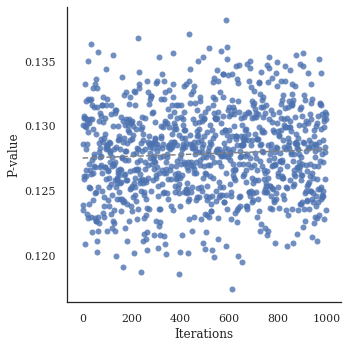

In [89]:
### MONTECARLO FOR P-VALUE ###

def relabel():
    
    #starting objects
    label = ['Linear'] * 62 + ['Quadratic'] * 79 + ['Cubic'] * 370
    comp_list = []
            
    while len(comp_list) <= 77:
        
        rand_num = int(np.random.randint(0, len(label), size=1))
        
        line = label[rand_num]
        
        comp_list.append(line)     
    
        label.remove(line)
    
    eme_list = label
    
    #non-straight proportion
    
    non_lin_eme = 1 - (eme_list.count('Linear') / len(eme_list)) 
    non_lin_comp = 1 - (comp_list.count('Linear') / len(comp_list))     
    diff_prop = non_lin_eme - non_lin_comp
    
    return diff_prop



#obtain p-value
def p_val(x):
    
    non_lin_eme = 1 - (eme_linear/eme_total)
    non_lin_comp = 1 - (comp_linear/comp_total)
    emp_diff = non_lin_eme - non_lin_comp
 
    outlayers = [i > emp_diff for i in x]
    
    num = outlayers.count(True)
       
    p_value = num / len(x)
    
    return p_value

#run simulations for asymptotic p-value
def montecarlo(iter1, iter2):
    
    p_values = []
    

    for i in range(iter1):      #how many p-values will be generated
    
        x = []
    
        for i in range(iter2):  #how many datapoints in the proportion difference histogram
            value = relabel()
            x.append(value)
    
        result = p_val(x)       #create the p-value and store in p_values list
    
        p_values.append(result)
        
    return p_values
    
def p_asym():
    
    #axis
    y = montecarlo(1000, 10000)          #get p-values from montecarlo()
    x = list(np.arange(len(y)))
    print('p-values', str(y))
    
    #create df for plot
    df = {'Iterations':x, 'P-value':y}
    df = pd.DataFrame(data=df, columns=df.keys())
    
    #open Parameters()
    model = 'Linear'
    start_params = Parameters()
    params = regressions().params(model, start_params)
    userfcn = regressions().implementation(params, x, y, model)
    minner = Minimizer(userfcn = regressions().implementation, params = params,fcn_args = (x, y, model))
    minimization = minner.minimize(method = 'leastsq') 
    res_vals = regressions().implementation(minimization.params, x, y, model)
    line_model = res_vals + y 
    
    opt_params = minimization.params
    opt_params = dict(opt_params.valuesdict())
    p = round(opt_params['d'], 4) 
    
    plt.gcf()
    #fig = plt.subplots()
    fig = sns.lmplot(data=df, x= 'Iterations', y='P-value', fit_reg=False, markers='o')
    text = 'P-value: ' + str(p)
    #plt.text(x=5, y=0.015,s=text, fontsize=12)
    down = min(list(df['P-value'])) - 0.001
    up= max(list(df['P-value'])) + 0.001
    plt.ylim(down, up)
    plt.plot(x, line_model, color='grey',linestyle='dashed')
       

    #plt.text(x=5, y=0.015, s=text)
    fig.savefig("../Results/Figures/new_Asym_pval")
    #plt.scatter(x_axis, y_axis)          #also works if needed to increase marker size from here
    #plt.plot(x_axis, line_model, color='red')
    
    result = 'This is the p-value --> ' + str(p)
    return result, p
    
p_asym()

### Figure of asymptotic p-value

In [85]:
#### ASYMPTOTIC P-VALUE ####

#axis
p_values = [0.1301, 0.1239, 0.1286, 0.1235, 0.1308, 0.1306, 0.1261, 0.1259, 0.1332, 0.1306, 0.1209, 0.13, 0.1282, 0.1319, 0.1266, 0.1299, 0.1261, 0.1232, 0.1302, 0.1286, 0.1305, 0.1321, 0.1295, 0.1229, 0.135, 0.1253, 0.1302, 0.1271, 0.124, 0.1266, 0.1305, 0.1252, 0.132, 0.1263, 0.123, 0.1321, 0.1363, 0.1316, 0.1218, 0.1305, 0.1274, 0.1264, 0.1243, 0.1298, 0.1329, 0.1269, 0.1276, 0.1278, 0.1315, 0.1229, 0.1248, 0.1332, 0.1268, 0.1249, 0.1227, 0.1227, 0.1336, 0.1294, 0.1329, 0.1203, 0.1315, 0.1211, 0.123, 0.1253, 0.1357, 0.1219, 0.1304, 0.1225, 0.1287, 0.128, 0.1276, 0.1283, 0.1268, 0.131, 0.127, 0.129, 0.1308, 0.1277, 0.1316, 0.125, 0.1264, 0.1316, 0.1322, 0.1233, 0.1303, 0.1288, 0.1238, 0.1245, 0.1291, 0.123, 0.1268, 0.1268, 0.1294, 0.1306, 0.1282, 0.1344, 0.1316, 0.1259, 0.1284, 0.1219, 0.1285, 0.1285, 0.1321, 0.1265, 0.1243, 0.1282, 0.1266, 0.1253, 0.1238, 0.1288, 0.126, 0.1281, 0.1272, 0.1287, 0.1279, 0.1232, 0.1309, 0.1316, 0.1255, 0.1269, 0.1247, 0.1276, 0.1221, 0.13, 0.1355, 0.1271, 0.1227, 0.1235, 0.1282, 0.1225, 0.127, 0.1258, 0.131, 0.1219, 0.1312, 0.1272, 0.1312, 0.1284, 0.12, 0.1253, 0.1259, 0.126, 0.1256, 0.1244, 0.1266, 0.1289, 0.13, 0.1264, 0.1249, 0.1292, 0.129, 0.1262, 0.1256, 0.1282, 0.1267, 0.1244, 0.1234, 0.1307, 0.1266, 0.1257, 0.1244, 0.1338, 0.1276, 0.1275, 0.1241, 0.1288, 0.1304, 0.1191, 0.1242, 0.1291, 0.1262, 0.1324, 0.1221, 0.1281, 0.1263, 0.1301, 0.1274, 0.1258, 0.1305, 0.1326, 0.1281, 0.124, 0.1211, 0.1258, 0.1287, 0.1304, 0.1297, 0.1301, 0.1274, 0.1305, 0.1227, 0.1317, 0.1295, 0.1289, 0.1322, 0.1265, 0.1251, 0.1302, 0.1238, 0.1252, 0.1303, 0.129, 0.1254, 0.1234, 0.1304, 0.1293, 0.1245, 0.1278, 0.13, 0.1266, 0.1327, 0.1202, 0.1256, 0.1253, 0.1316, 0.126, 0.1326, 0.1247, 0.1298, 0.1279, 0.1267, 0.1242, 0.1272, 0.1266, 0.1228, 0.1283, 0.1282, 0.1267, 0.1236, 0.1368, 0.1329, 0.1332, 0.1302, 0.1342, 0.1258, 0.1256, 0.1263, 0.1274, 0.1298, 0.1187, 0.1287, 0.125, 0.1281, 0.1307, 0.1299, 0.1259, 0.1289, 0.1211, 0.1256, 0.1294, 0.1229, 0.1249, 0.1217, 0.1247, 0.1306, 0.1258, 0.1267, 0.1282, 0.1272, 0.1244, 0.1213, 0.1231, 0.1257, 0.1335, 0.1237, 0.1218, 0.1204, 0.126, 0.1288, 0.127, 0.1326, 0.1236, 0.1286, 0.1292, 0.1317, 0.1279, 0.1321, 0.1284, 0.1275, 0.1323, 0.1286, 0.125, 0.1323, 0.131, 0.1271, 0.1287, 0.1287, 0.1311, 0.1275, 0.1283, 0.1258, 0.1277, 0.1273, 0.1216, 0.1267, 0.1291, 0.1287, 0.1272, 0.129, 0.1303, 0.1262, 0.1333, 0.126, 0.1227, 0.1286, 0.1335, 0.1281, 0.1268, 0.1284, 0.1206, 0.1254, 0.1246, 0.1264, 0.1223, 0.1236, 0.1353, 0.1276, 0.1236, 0.1226, 0.1216, 0.1292, 0.13, 0.1321, 0.1291, 0.134, 0.1266, 0.1283, 0.1255, 0.1248, 0.1299, 0.1286, 0.1277, 0.1264, 0.1249, 0.1215, 0.1335, 0.1321, 0.1209, 0.1302, 0.1326, 0.1304, 0.1201, 0.1272, 0.1267, 0.1264, 0.1278, 0.1276, 0.1302, 0.1248, 0.1259, 0.1244, 0.1284, 0.1313, 0.1285, 0.1299, 0.1328, 0.1285, 0.1266, 0.1282, 0.1308, 0.1283, 0.1238, 0.1288, 0.1259, 0.1269, 0.1316, 0.1285, 0.1294, 0.1284, 0.1332, 0.1235, 0.1356, 0.1322, 0.1311, 0.1302, 0.1288, 0.1298, 0.1288, 0.13, 0.1249, 0.1263, 0.1254, 0.1316, 0.1269, 0.1298, 0.1259, 0.1273, 0.126, 0.1306, 0.1285, 0.1264, 0.1316, 0.1252, 0.1261, 0.1255, 0.1186, 0.1293, 0.1248, 0.1275, 0.1238, 0.1203, 0.126, 0.1307, 0.1278, 0.1316, 0.1271, 0.1262, 0.1291, 0.1216, 0.1282, 0.1305, 0.1286, 0.1284, 0.1301, 0.1311, 0.1249, 0.1331, 0.1272, 0.1297, 0.1271, 0.1297, 0.1284, 0.1291, 0.1251, 0.1249, 0.1332, 0.1287, 0.1251, 0.1256, 0.1248, 0.1268, 0.1272, 0.1202, 0.1266, 0.1242, 0.1335, 0.1228, 0.1244, 0.1371, 0.1344, 0.1318, 0.1286, 0.1293, 0.1249, 0.1272, 0.127, 0.1325, 0.1283, 0.1285, 0.1219, 0.1253, 0.1283, 0.1327, 0.1305, 0.1269, 0.1288, 0.1264, 0.1331, 0.1267, 0.123, 0.1318, 0.1278, 0.1284, 0.1302, 0.1281, 0.1264, 0.1272, 0.1243, 0.1292, 0.1245, 0.1312, 0.1296, 0.1293, 0.1252, 0.1288, 0.135, 0.1303, 0.128, 0.1298, 0.1245, 0.1319, 0.1274, 0.1322, 0.127, 0.1253, 0.1308, 0.1289, 0.1228, 0.128, 0.1304, 0.125, 0.1284, 0.121, 0.1286, 0.126, 0.1276, 0.1353, 0.1306, 0.1305, 0.1269, 0.1292, 0.1311, 0.1232, 0.1205, 0.1264, 0.1263, 0.1246, 0.1218, 0.1276, 0.1295, 0.1243, 0.1254, 0.1231, 0.1278, 0.1281, 0.1314, 0.127, 0.1284, 0.123, 0.136, 0.1245, 0.127, 0.1288, 0.1301, 0.1261, 0.1234, 0.1286, 0.1234, 0.124, 0.1276, 0.1246, 0.1297, 0.1204, 0.1291, 0.1322, 0.126, 0.1316, 0.1334, 0.1337, 0.131, 0.1199, 0.1272, 0.1321, 0.1306, 0.1306, 0.1293, 0.1242, 0.1281, 0.1305, 0.125, 0.1282, 0.1306, 0.1343, 0.128, 0.1229, 0.1311, 0.1213, 0.1335, 0.1272, 0.1245, 0.1282, 0.1257, 0.1253, 0.1278, 0.1326, 0.1247, 0.1269, 0.1302, 0.1277, 0.1358, 0.1295, 0.1247, 0.1277, 0.128, 0.134, 0.1308, 0.134, 0.1322, 0.1253, 0.1287, 0.1241, 0.1241, 0.1278, 0.1297, 0.1283, 0.1297, 0.1277, 0.1264, 0.1247, 0.1382, 0.1207, 0.1236, 0.1361, 0.1293, 0.1352, 0.1312, 0.1276, 0.1282, 0.1339, 0.1315, 0.1308, 0.1297, 0.1289, 0.1255, 0.128, 0.1274, 0.1278, 0.1309, 0.1246, 0.1228, 0.1249, 0.134, 0.132, 0.1292, 0.1174, 0.1282, 0.1266, 0.1271, 0.1315, 0.1262, 0.1312, 0.126, 0.1309, 0.13, 0.1266, 0.1267, 0.1258, 0.1233, 0.1292, 0.129, 0.1346, 0.1292, 0.1285, 0.1336, 0.1226, 0.1235, 0.1237, 0.1333, 0.12, 0.1319, 0.1245, 0.1347, 0.1311, 0.1271, 0.1238, 0.1246, 0.1281, 0.1276, 0.1306, 0.1292, 0.1277, 0.1285, 0.1285, 0.1195, 0.1285, 0.1301, 0.1286, 0.1271, 0.1261, 0.129, 0.1285, 0.1307, 0.1292, 0.1289, 0.1263, 0.1309, 0.129, 0.1277, 0.1297, 0.1298, 0.1266, 0.1257, 0.1238, 0.1236, 0.1348, 0.1238, 0.1278, 0.1289, 0.1271, 0.1311, 0.1294, 0.1335, 0.1249, 0.131, 0.1249, 0.1345, 0.135, 0.1246, 0.1275, 0.1268, 0.1285, 0.133, 0.125, 0.1306, 0.126, 0.1289, 0.1241, 0.1319, 0.1256, 0.1316, 0.1243, 0.1248, 0.1327, 0.127, 0.1318, 0.1307, 0.1294, 0.1258, 0.1279, 0.1313, 0.1307, 0.131, 0.1275, 0.1249, 0.123, 0.129, 0.129, 0.1266, 0.1244, 0.1309, 0.1258, 0.129, 0.1234, 0.1299, 0.1333, 0.1334, 0.1285, 0.1219, 0.1273, 0.1325, 0.1286, 0.1342, 0.1224, 0.1315, 0.1295, 0.1297, 0.1269, 0.132, 0.1281, 0.1315, 0.128, 0.1307, 0.1322, 0.1266, 0.1259, 0.1295, 0.1249, 0.1251, 0.1264, 0.131, 0.1221, 0.1249, 0.1256, 0.1316, 0.1254, 0.1265, 0.1249, 0.1347, 0.1216, 0.126, 0.1334, 0.1219, 0.1285, 0.1353, 0.1274, 0.1345, 0.1305, 0.1254, 0.1278, 0.1254, 0.1237, 0.1246, 0.1312, 0.1286, 0.1282, 0.1252, 0.1269, 0.1303, 0.1236, 0.1337, 0.127, 0.1251, 0.1309, 0.1297, 0.1275, 0.1243, 0.1295, 0.1241, 0.1271, 0.127, 0.128, 0.121, 0.1244, 0.1341, 0.1284, 0.1248, 0.1302, 0.1283, 0.1331, 0.1349, 0.1264, 0.1296, 0.1261, 0.1253, 0.1292, 0.1237, 0.1293, 0.1311, 0.1273, 0.1273, 0.1267, 0.1279, 0.1317, 0.1306, 0.1335, 0.1297, 0.1261, 0.1274, 0.126, 0.132, 0.1272, 0.126, 0.1289, 0.1247, 0.1324, 0.1244, 0.1305, 0.1301, 0.1284, 0.1299, 0.1335, 0.1314, 0.1346, 0.1253, 0.1282, 0.1235, 0.1299, 0.1252, 0.1207, 0.1306, 0.1269, 0.1315, 0.1231, 0.1285, 0.1291, 0.1319, 0.1299, 0.1288, 0.1283, 0.1304, 0.1299, 0.1258, 0.1343, 0.1296, 0.1316, 0.128, 0.1278, 0.1236, 0.1325, 0.1316, 0.1318, 0.1332, 0.1254, 0.132, 0.121, 0.1273, 0.1255, 0.1278, 0.1266, 0.1263, 0.1261, 0.1287, 0.1331, 0.1307, 0.1355, 0.1294, 0.1286, 0.1288, 0.1286, 0.1283, 0.1217, 0.1268, 0.1291, 0.1268, 0.1282, 0.1235, 0.1266, 0.1272, 0.1301, 0.1278, 0.1269, 0.1313, 0.124, 0.1348, 0.1276, 0.1262, 0.124, 0.1315, 0.1258, 0.1262, 0.1271, 0.1308, 0.1241, 0.1222, 0.1346, 0.1356, 0.1288, 0.1324, 0.1301, 0.1236, 0.1287, 0.1248, 0.132, 0.1227, 0.1297, 0.1304, 0.125, 0.127, 0.1281, 0.1242, 0.1254, 0.1265, 0.1243, 0.1284, 0.1302, 0.1255, 0.1341, 0.1257, 0.1236, 0.1289, 0.1283, 0.1271, 0.1261, 0.125, 0.1309, 0.1305, 0.1332, 0.1287, 0.1318, 0.125, 0.1321, 0.1244, 0.1214, 0.1264, 0.126, 0.1284, 0.1248, 0.1241, 0.1292, 0.1269, 0.1297, 0.1225, 0.123, 0.1276, 0.1281, 0.1286, 0.1285, 0.1246, 0.13, 0.1238, 0.1211, 0.1229, 0.1302, 0.1259, 0.1308, 0.1251, 0.1241, 0.1269, 0.1282, 0.1288, 0.1231, 0.1352, 0.1317, 0.1273, 0.1318, 0.1251, 0.1244, 0.1316, 0.1253, 0.1341, 0.1298, 0.1247, 0.1309, 0.1245, 0.1278, 0.1246, 0.125, 0.1289, 0.1272, 0.1228, 0.1304, 0.1299, 0.1306, 0.1259, 0.1311, 0.128, 0.1284, 0.1305, 0.1235, 0.1309]
x = np.arange(len(p_values))
y = p_values

#model zero-polynomial implementation
model = 'Zero'
start_params = Parameters()
params = regressions().params(model, start_params)
userfcn = regressions().implementation(params, x, y, model)
minner = Minimizer(userfcn = regressions().implementation, params = params,fcn_args = (x, y, model))  
minimization = minner.minimize(method = 'leastsq')   
residuals = regressions().implementation(minimization.params, x, y, model)
line_model = residuals + y

#get p-value
opt_params = minimization.params
opt_params = dict(opt_params.valuesdict())
p = opt_params['d']

#plot
plt.figure(figsize=(12, 8))
plt.scatter( np.arange(len(p_values)), p_values,s=6)
plt.plot(x, line_model, ls='--', color='red', linewidth=2)
plt.savefig('../Results/Figures/P_val_NEW')
plt.close()

The asymptotic p-value: 0.1279


### Metadata

In [88]:
## CREATE PDF WITH GRAPHS ## 
with PdfPages('../Results/Metadata/eme_graphs.pdf') as pp:
    for i, ID in enumerate(eme_work):  
        fig = plt.figure(figsize=(10, 10))
        figures(ID, eme_dic)
        pp.savefig(fig)
        plt.close()
        

with PdfPages('../Results/Metadata/comp_graphs.pdf') as pp:
    for i, ID in enumerate(comp_work):  
        fig = plt.figure(figsize=(10, 10))
        figures(ID, comp_dic)
        pp.savefig(fig)
        plt.close()